In [2]:
import json
import torch
from torchvision import models, transforms
from PIL import Image
import torchvision.transforms.functional as TF
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import torch.nn.functional as F
# dev for scaling

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.metrics import confusion_matrix



def refine_paths(experiment,args):



    path_list = experiment['train']

    def load_image(filename, crop_size=256, aligned=True, img_size=280):
        img = Image.open(filename)
        img = img.convert('RGB')
        
        if aligned:
            img = TF.resize(img, crop_size, Image.BICUBIC)
            img = TF.to_tensor(img)
            img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        else:
            img = TF.resize(img, img_size, Image.BICUBIC)
            angle = transforms.RandomRotation.get_params([-10, 10])
            img = TF.rotate(img, angle, fill=(0,))
            i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
            img = TF.crop(img, i, j, h, w)
            img = TF.to_tensor(img)
            img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            img = img.to(torch.float32)
        return img

    def embedding_concat(x, y):
        B, C1, H1, W1 = x.size()
        _, C2, H2, W2 = y.size()
        s = int(H1 / H2)
        x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
        x = x.view(B, C1, -1, H2, W2)
        z = torch.zeros(B, C1 + C2, x.size(2), H2, W2).to(device)
        for i in range(x.size(2)):
            z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
        z = z.view(B, -1, H2 * W2)
        z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
        return z

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    featuremaps = []
    backbone = models.resnet18(pretrained=True).to(device)
    backbone.eval()
    outputs = []

    def hook(module, input, output):
        outputs.append(output)

    backbone.layer1[-1].register_forward_hook(hook)
    backbone.layer2[-1].register_forward_hook(hook)
    backbone.layer3[-1].register_forward_hook(hook)

    img_list = [load_image(path, aligned=False) for path in path_list]

    with torch.no_grad():
        for img in img_list:
            img = img.unsqueeze(0).to(device)
            outputs = []
            _ = backbone(img)
            outputs = embedding_concat(embedding_concat(outputs[0], outputs[1]), outputs[2])
            featuremaps.append(outputs.cpu().numpy())


    shuffled_final = np.array(featuremaps).squeeze()

    isolation_outliers = []
    lof_outliers = []

    for i in range(shuffled_final.shape[1]):
        feature_maps = shuffled_final[:, i, :, :]
        flattened_feature_maps = feature_maps.reshape(feature_maps.shape[0], -1)

        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(flattened_feature_maps)

        clf_isolation = IsolationForest(contamination=args.assumed_contamination_rate)
        outliers_isolation = clf_isolation.fit_predict(features_scaled)
        isolation_outliers.append(outliers_isolation)

        clf_lof = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
        outliers_lof = clf_lof.fit_predict(features_scaled)
        lof_outliers.append(outliers_lof)

    isolation_outliers = np.array(isolation_outliers)
    lof_outliers = np.array(lof_outliers)

    isolation_column_sums = isolation_outliers.sum(axis=0)
    lof_column_sums = lof_outliers.sum(axis=0)


    remove_inds=np.array(lof_column_sums).argsort()[:int(args.assumed_contamination_rate * len(lof_column_sums))]
    selected_paths = [path_list[i] for i in remove_inds]
    refined_paths= [path for path in path_list if path not in selected_paths]

    experiment['isoforest_scores'] = isolation_column_sums.tolist()
    experiment['lof_scores'] = lof_column_sums.tolist()
    experiment['lof_refined_paths'] = refined_paths

    return experiment

    # with open(experiment_path, 'w') as file:
    #     json.dump(experiment, file)
        


In [6]:
################ Only MSE

import torch
import json
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the TrainOptions class
class TrainOptions:
    def __init__(self, category):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.assumed_contamination_rate = 0.1

# Initialize the options
category = "leather"
args = TrainOptions(category)
torch.manual_seed(args.seed)

# Load the experiment paths
experiment_path = '/home/bule/projects/UTRAD/results/mvtec/contamination_10/Exp_07_06_run_1-leather/experiment_paths.json'
with open(experiment_path, 'r') as file:
    experiment = json.load(file)

# Get the list of training image paths
path_list = experiment['train']
labels = np.array([0 if 'good' in path else 1 for path in experiment['train']])


def load_image(filename, crop_size=256, aligned=True, img_size=280):
    img = Image.open(filename)
    img = img.convert('RGB')
    
    if aligned:
        img = TF.resize(img, crop_size, Image.BICUBIC)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    else:
        img = TF.resize(img, img_size, Image.BICUBIC)
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
        img = TF.crop(img, i, j, h, w)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img = img.to(torch.float32)
    return img

def embedding_concat(x, y):
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    s = int(H1 / H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, -1, H2, W2)
    z = torch.zeros(B, C1 + C2, x.size(2), H2, W2).to(device)
    for i in range(x.size(2)):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
    return z

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
featuremaps = []
backbone = models.resnet18(pretrained=True).to(device)
backbone.eval()
outputs = []

def hook(module, input, output):
    outputs.append(output)

backbone.layer1[-1].register_forward_hook(hook)
backbone.layer2[-1].register_forward_hook(hook)
backbone.layer3[-1].register_forward_hook(hook)

img_list = [load_image(path, aligned=False) for path in path_list]

with torch.no_grad():
    for img in img_list:
        img = img.unsqueeze(0).to(device)
        outputs = []
        _ = backbone(img)
        outputs = embedding_concat(embedding_concat(outputs[0], outputs[1]), outputs[2])
        featuremaps.append(outputs.cpu().numpy())


shuffled_final = np.array(featuremaps).squeeze()







/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Convert the image list to a numpy array for dimensionality reduction
img_array = np.array([img.flatten() for img in shuffled_final])
img_array.shape


iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(img_array)
iso_scores = -iso_forest.decision_function(img_array)
iso_pred = iso_forest.predict(img_array)

# Convert Isolation Forest output to binary labels: -1 for outliers becomes 1 (anomaly), 1 for inliers becomes 0 (good)
iso_pred = np.where(iso_pred == -1, 1, 0)

# Compute precision-recall curve and average precision score for Isolation Forest
iso_precision, iso_recall, _ = precision_recall_curve(labels, iso_scores)
iso_average_precision = average_precision_score(labels, iso_scores)

# Compute ROC curve and ROC AUC for Isolation Forest
iso_fpr, iso_tpr, _ = roc_curve(labels, iso_scores)
iso_roc_auc = auc(iso_fpr, iso_tpr)


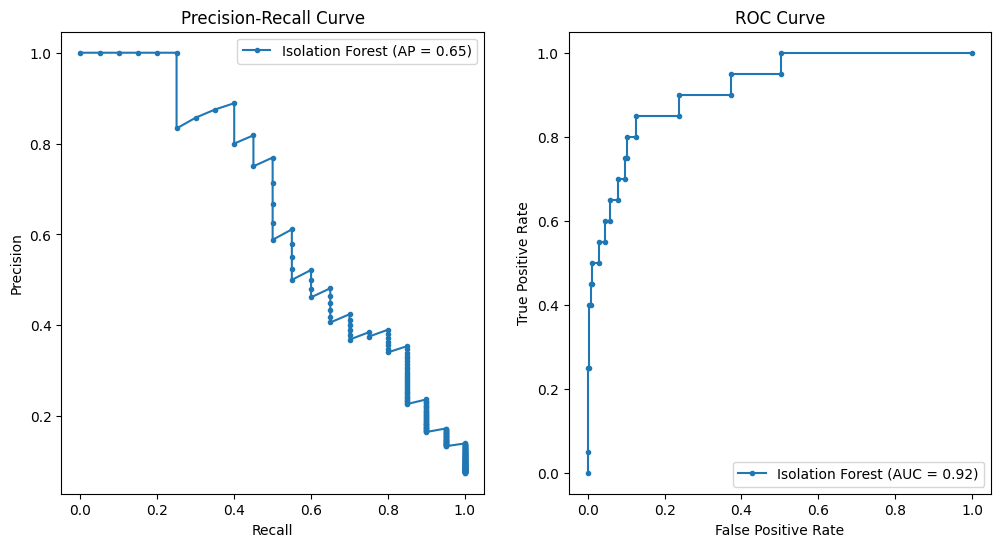

In [8]:
# Plot the precision-recall curve and ROC curve side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(iso_recall, iso_precision, marker='.', label=f'Isolation Forest (AP = {iso_average_precision:.2f})')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve')
ax1.legend()

# ROC curve
ax2.plot(iso_fpr, iso_tpr, marker='.', label=f'Isolation Forest (AUC = {iso_roc_auc:.2f})')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend()

In [ ]:
shuffled_final.shape

(265, 448, 64, 64)